---
Vérifier qu'on n'est pas en 3.10.2 (sinon PyTorch ne marchera pas)

In [123]:
import sys
print(sys.version)

3.9.10 (tags/v3.9.10:f2f3f53, Jan 17 2022, 15:14:21) [MSC v.1929 64 bit (AMD64)]


---
Imports - notemment de clubs_gym (https://github.com/fschlatt/clubs_gym)

In [124]:
import gym
import clubs_gym
from clubs_gym.agent.base import BaseAgent

import time
import random
random.seed(1998)
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

---
Liste des environnements disponibles

In [125]:
clubs_gym.ENVS

['LeducTwoPlayer-v0',
 'KuhnTwoPlayer-v0',
 'KuhnThreePlayer-v0',
 'LimitHoldemTwoPlayer-v0',
 'LimitHoldemSixPlayer-v0',
 'LimitHoldemNinePlayer-v0',
 'NoLimitHoldemTwoPlayer-v0',
 'NoLimitHoldemSixPlayer-v0',
 'NoLimitHoldemNinePlayer-v0',
 'NoLimitHoldemBbAnteNinePlayer-v0',
 'PotLimitOmahaTwoPlayer-v0',
 'PotLimitOmahaSixPlayer-v0',
 'PotLimitOmahaNinePlayer-v0',
 'ShortDeckTwoPlayer-v0',
 'ShortDeckSixPlayer-v0',
 'ShortDeckNinePlayer-v0']

Ne nous intéressera que `NoLimitHoldemTwoPlayer-v0` et `NoLimitHoldemSixPlayer-v0`

---
Ouvrons `NoLimitHoldemTwoPlayer-v0`.

In [126]:
env_str = "NoLimitHoldemTwoPlayer-v0"
num_players = 2  # heads-up
num_streets = 4  # texas hold'em
blinds = [1, 2]  # as on the tables on which we used to play @Jean
antes = 0  # a bit weird to have antes in a heads-up I reckon (single ints are expanded to the number of players so could've inputted a list)
raise_sizes = ['inf', 'inf', 'inf', 'inf']  # yes the documentation is wrong, 'inf' should be used and not float('inf')
num_raises = 'inf'  # max number of bets for each street* (including preflop)
num_suits = 4  # number of suits to use in deck (obviously 4 otherwise I mean it's weird)
num_ranks = 13  # same, obviously 13 (A, 2, 3, 4, 5, 6, 7, 8, 9, T, J, Q, K)
num_hole_cards = 2  # **
mandatory_num_hole_cards = 0  # you can use the fives on the board and it will end up being a draw if your enemy does it too
num_community_cards = [0, 3, 1, 1]  # preflop, flop, turn, river
start_stack = 100  # as on the tables on which we used to play @Jean (actually it was any integer between 80 and 200)
n_cards_for_hand = 5  # texas hold'em
order = ['sf', 'fk', 'fh', 'fl', 'st', 'tk', 'tp', 'pa', 'hc']  # most likely optional, but just to make sure we're working with the right order

config_dict = {'num_players': num_players,
               'num_streets': num_streets,
               'blinds': blinds,
               'antes': antes,
               'raise_sizes': raise_sizes,
               'num_raises': num_raises,
               'num_suits': num_suits,
               'num_ranks': num_ranks,
               'num_hole_cards': num_hole_cards,
               'mandatory_num_hole_cards': mandatory_num_hole_cards,
               'num_community_cards': num_community_cards,
               'start_stack': start_stack,
               'num_cards_for_hand': n_cards_for_hand,
               'order': order}

---
Un peu de vocabulaire pour les zguegs (là où y avait des * au-dessus):
- \* A card that’s dealt in a particular betting round, in many poker variants, is called a **street**. For example, in Texas Hold’em and Omaha, the community cards are referred to as the flop, turn and river, with the turn and river sometimes referred to as Fourth Street and Fifth Street.
- ** The term **hole cards' in poker signals that the cards are private cards that should only be viewed by the player. The dealer deals hole cards face down and players should ensure that the value of those cards remains secret.

---
`obs` est illisible donc on fait une fonction `print_obs` pour avoir des jolis prints sur ce qu'il se passe.

In [127]:
def print_obs(obs):
    """
    Fancy print of stats for the clubs gym poker gym.
    All Cards displayed (on voit les cartes de tout le monde quoi)
    
    param: obs: le premier argument renvoyé par env.step
    return: nada
    """
    for _ in range(3):
        print('\n')
    print('------------------- Players\' stacks -------------------')
    print(f"player_0: {obs['stacks'][0]}\n" + \
          f"player_1: {obs['stacks'][1]}")
    print('------------------- Game Stats -------------------')
    print(f'community_cards: {obs["community_cards"]}')
    print(f'Dealer/Button: {obs["button"] % 2}')
    print(f'Pot: {obs["pot"]}')
    print(f'Commits: player_0: {obs["street_commits"][0]} |||  player_1: {obs["street_commits"][1]}')

    if not obs['action'] == -1:
        print(f"\n---------------- player {obs['action']}'s turn ----------------")
        print(f'hole_cards: {obs["hole_cards"]}')
        print(f'call: {obs["call"]}, min_raise: {obs["min_raise"]}, max_raise: {obs["max_raise"]}', end='\n\n')
    else:
        print('\n[INFO] - End of the Game.')

---
# Main

`env.act` gère à quel agent c'est de jouer et call la méthode `act` de l'agent. Tout agent doit donc avoir une méthode `act()`.

`env.step` demande un argument, cela doit être un integer qui correspond à ce que vous voulez miser. 
- Si la mise est inférieure à la mise minimum, vous vous couchez. 
- Si la mise est supérieure à la mise maximum (en no limit, ça veut dire vous voulez miser plus que ce que vous détenez) alors all in.

Ici, on code trois agents. AllInFoldQLearningAgent, RandomAllInFold et HumanRandomAllInFold.

In [128]:
class RandomAllInFold(BaseAgent):
    '''
    This agent bets everyting or folds (50/50 chance).
    '''
    def __init__(self, player_id):
        self.player_id = player_id

    def act(self, info_dict):
        available_chips = info_dict['stacks'][self.player_id]
        draw = random.random()
        if draw >= 0.5:  # >= and not > because random.random() returns random floating point number in the range [0.0, 1.0)
            action = 1 
        else:
            action = 0

        ## outpu  
        if action == 0:
            return(0)
        else:
            return(available_chips)

In [129]:
class HumanRandomAllInFold(BaseAgent):
    """
    The human can choose between two actions, all in or fold.
    """
    def __init__(self, player_id):
        self.player_id = player_id

    def act(self, info_dict):
        available_chips = info_dict['stacks'][self.player_id]
        
        action = -1
        while action != 0 and action != 1:
            action = int(input("Do you want to push (1) or fold (0)?"))
            
        if action == 0:
            return(0)
        else:
            return(available_chips)

In [130]:
class AllInFoldQLearningAgent(BaseAgent):
    """
    Model-free reinforcement learning algorithm to learn the value of an action (called here agent_decision, cf. below) 
    in a particular state (here 2 hole cards).
    agent_decision:
        - 0: folds
        - 1: all-in
    We call decision the usual term action because the library clubs_gym uses action to determine whose next to play. So, to avoid
    any confusion, action will be reserved to the use clubs_gym makes it of.
    """
    
    
    def __init__(self, player_id, agent_init_info):
        self.player_id = player_id

        self.state_size = agent_init_info["state_size"]  # size of the iterable state
        self.num_agent_decision = agent_init_info["num_agent_decision"]  # how many decisions can the agent make
        self.epsilon = agent_init_info["epsilon"]  # exploration, got to be set to 0 after training when we want an "optimal" agent
        
        self.q = {}  # policy the agent is learning
        
        self.step_size_initial = agent_init_info["step_size"]
        
        if self.step_size_initial:
            # If step_size is fixed
            self.step_size = agent_init_info["step_size"]
        else:
            # The step-size is then 1/N(A), where N(A) is the number of times action A was selected. 
            # This is the same as computing a sample average.
            self.count = {}  # number of times a given decision has been made in a particular state
        
        self.discount = agent_init_info["discount"]  # gamma
        
        self.has_already_made_a_decision = False 


    def agent_start(self, state):
        # Chooses action using epsilon greedy.
        self.has_already_made_a_decision = True

        tuple_representing_state = (str(state[0]), str(state[1]))
        self.q.setdefault(tuple_representing_state, [0]*self.num_agent_decision)  # un 0 pour fold, un 0 pour all in
        # on n'a pas besoin de self.count parce qu'on n'update pas les q values, 
        # on a besoin de self.q pour faire la décision par contre
        
        if random.random() < self.epsilon:
            agent_decision = random.randint(0, self.num_agent_decision-1)  # random decision selection
        else:
            agent_decision = self.argmax(self.q[tuple_representing_state])  # greedy decision selection
        self.prev_state = tuple_representing_state
        self.prev_agent_decision = agent_decision
        return agent_decision
    
    
    def agent_step(self, reward, state):
        # Chooses action using epsilon greedy.
        # Updates self.q
        
        tuple_representing_state = (str(state[0]), str(state[1]))
        if not self.step_size_initial:
            self.count.setdefault(self.prev_state, [0]*self.num_agent_decision)
            self.count[self.prev_state][self.prev_agent_decision] += 1
            self.step_size = 1/self.count[self.prev_state][self.prev_agent_decision]
        self.q.setdefault(tuple_representing_state, [0]*self.num_agent_decision)  # un 0 pour fold, un 0 pour all in
        
        if random.random() < self.epsilon:
            agent_decision = random.randint(0, self.num_agent_decision-1)  # random decision selection
        else:
            agent_decision = self.argmax(self.q[tuple_representing_state])  # greedy decision selection
        
        previous_estimates_list = self.q[self.prev_state]
        previous_estimates_list[self.prev_agent_decision] += \
            self.step_size*(reward + self.discount * np.max(self.q[tuple_representing_state]) - self.q[self.prev_state][self.prev_agent_decision])
        self.q[self.prev_state] = previous_estimates_list
        
        self.prev_state = tuple_representing_state
        self.prev_agent_decision = agent_decision
        return agent_decision
    
    
    def agent_end(self, reward):
        # Updates self.q
        if self.has_already_made_a_decision:  
            # sometimes, the end is reached before the agent has had to make any decision. This typically happens when
            # the agent is the BB and everyone folds. In this case, you haven't made any decision so you can't really
            # infer anything about the strength of your hand.
            if not self.step_size_initial:
                self.count.setdefault(self.prev_state, [0]*self.num_agent_decision)
                self.count[self.prev_state][self.prev_agent_decision] += 1
                self.step_size = 1/self.count[self.prev_state][self.prev_agent_decision]
            self.q.setdefault(self.prev_state, [0]*self.num_agent_decision)  # un 0 pour fold, un 0 pour all in
            previous_estimates_list = self.q[self.prev_state]
            previous_estimates_list[self.prev_agent_decision] += self.step_size*(reward + self.discount * 0 - self.q[self.prev_state][self.prev_agent_decision])
            self.q[self.prev_state] = previous_estimates_list



    def act(self, info_dict):
        reward = info_dict['rewards'][self.player_id]
        state = info_dict['state']
        number_of_chips = info_dict['stacks'][self.player_id]
        

        if not self.has_already_made_a_decision:
            agent_decision = self.agent_start(state)

        elif self.has_already_made_a_decision:
            agent_decision = self.agent_step(reward, state)

        if agent_decision == 0:
            return(0)
        elif agent_decision == 1:
            return(number_of_chips)
        else:
            print(f"Error on variable agent_decision (is equal to {agent_decision} which is illegal)")
        
        
    def argmax(self, q_values):
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return random.choice(ties)

    
    def epsilon_decay(self):
        self.epsilon = self.epsilon * 0.99

        
    @staticmethod
    def load(path):
        obj = pickle.load(open(path,'wb'))
        return(obj)

Epsilon parameters playaround

In [131]:
epsilon_depart = 1
num_episodes = 1000000

print(f"Epsilon part de {epsilon_depart} et finira à {1*0.99**(num_episodes/100)}")
print("\n")

Epsilon part de 1 et finira à 2.2487748498162805e-44




Trainings of the different Agents against the RandomAllInFold Agent

The different agents only learn to be on one side of the game (reset_button = True !!!!), en l'occurence, ici, on apprend le comportement petite blinde (0) puis grosse blinde (1).

In [132]:
agents_finaux = [[], []]
stacks_a_la_fin_finaux = [[], []]
for big_blind_agent in [0, 1]:
    print(f"L'agent est big_blind : {big_blind_agent == 1}")
    for i, step_size in enumerate([False, 0.01, 0.1]):
        clubs_gym.envs.register({env_str: config_dict})
        env = gym.make(env_str)
        q_learning_agent_info = {"state_size": 2, "num_agent_decision": 2 , "epsilon": 1, "step_size": step_size, "discount": 1.0}
        if big_blind_agent:
            agents = [RandomAllInFold(0), AllInFoldQLearningAgent(1, q_learning_agent_info)]
        else:
            agents = [AllInFoldQLearningAgent(0, q_learning_agent_info), RandomAllInFold(1)]
        env.register_agents(agents)

        # Start the game
        stacks_a_la_fin = []  # pour plot l'évolution du stack_size à la fin
        for episodes in tqdm(range(num_episodes), position = 0):
            obs = env.reset(reset_stacks = True, reset_button = True)

            # create a dict containing all necessary info for q learning agent
            info_dict = {}
            info_dict['rewards'] = [0, 0]
            info_dict['state'] = obs['hole_cards']
            info_dict['stacks'] = obs['stacks']

            while True:
                bet = env.act(info_dict)
                obs, rewards, done, info = env.step(bet)  
                # updata dict
                info_dict = {}
                info_dict['rewards'] = rewards
                info_dict['state'] = obs['hole_cards']
                info_dict['stacks'] = obs['stacks']


                # print_obs(obs)
                if all(done):
                    stacks_a_la_fin.append(obs['stacks'])
                    agents[big_blind_agent].agent_end(rewards[big_blind_agent])
                    # agents[1].agent_end(rewards[1])

                    if episodes % 100 == 0:
                        agents[big_blind_agent].epsilon_decay()
                    break
        stacks_a_la_fin_finaux[big_blind_agent].append(stacks_a_la_fin)
        agents_finaux[big_blind_agent].append(agents[big_blind_agent])
        env.close()

    print("\n")

L'agent est big_blind : False


100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:50<00:00, 19691.88it/s]




L'agent est big_blind : True


100%|█████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:55<00:00, 18031.90it/s]

Pour avoir un feel de ce à quoi ressemble `stacks_a_la_fin_finaux` :

In [133]:
print(len(stacks_a_la_fin_finaux))
print(len(stacks_a_la_fin_finaux[0]))
print(len(stacks_a_la_fin_finaux[0][0]))
print(len(stacks_a_la_fin_finaux[0][0][0]))
print("\n")

2
3
1000000
2




Quelques exemples de la policy de l'agent sur quelques pires et quelques meilleures mains :

In [134]:
for big_blind_agent in [0, 1]:
    print(f"L'agent est big_blind : {big_blind_agent == 1}")
    for agent in agents_finaux[big_blind_agent]:
        print(f"Agent à step_size = {agent.step_size_initial}")
        if not agent.step_size_initial:
            for mains_preflop in [('A♥', 'A♦'), ('A♥', 'A♣'), ('A♥', 'A♠'), ('2♥', '7♦'), ('2♥', '7♣'), ('2♥', '7♠')]:
                print(f"{mains_preflop}: {agent.q[mains_preflop]}. La main a été jouée {agent.count[mains_preflop]} de fois")
        else:
            for mains_preflop in [('A♥', 'A♦'), ('A♥', 'A♣'), ('A♥', 'A♠'), ('2♥', '7♦'), ('2♥', '7♣'), ('2♥', '7♠')]:
                print(f"{mains_preflop}: {agent.q[mains_preflop]}.")
        print("\n")

L'agent est big_blind : False
Agent à step_size = False
('A♥', 'A♦'): [-0.18068495008680557, 19.274983054870432]. La main a été jouée [8, 810] de fois
('A♥', 'A♣'): [0, 21.601172782540893]. La main a été jouée [0, 772] de fois
('A♥', 'A♠'): [12.984867160454204, 19.047207123824414]. La main a été jouée [6, 740] de fois
('2♥', '7♦'): [1.337278713679397, -26.195312500000004]. La main a été jouée [720, 6] de fois
('2♥', '7♣'): [1.189405826367422, -14.292945831843255]. La main a été jouée [760, 6] de fois
('2♥', '7♠'): [1.220450655435427, -12.0]. La main a été jouée [760, 4] de fois


Agent à step_size = 0.01
('A♥', 'A♦'): [0.0011433049368985999, 20.923876304273538].
('A♥', 'A♣'): [-0.027686075662878992, 17.002899377891165].
('A♥', 'A♠'): [-0.0100920319457059, 12.499144695161528].
('2♥', '7♦'): [-0.2085300547367384, -1.0193827865273217].
('2♥', '7♣'): [-0.1437684711016665, -0.936112204967784].
('2♥', '7♠'): [-0.08587768819126082, -0.9057223101010391].


Agent à step_size = 0.1
('A♥', 'A♦'):

Comparaison des stacks moyens à la fin du joueur 0 (Agent Q-learning) et du joueur 1 (Agent Random), keep in mind that calling the mehod epsilon_decay() fait que que le joueur 0 (Agent Q-learning) explore de moins en moins dans les bails!!

Différents step_size:
- Q-learning Agent Romain: step_size = False
- Q-learning Agent Timotai: step_size = 0.1
- Q-learning Agent Timothée: step_size = 0.01

Une génération = 100 épisodes

L'agent est big_blind : False


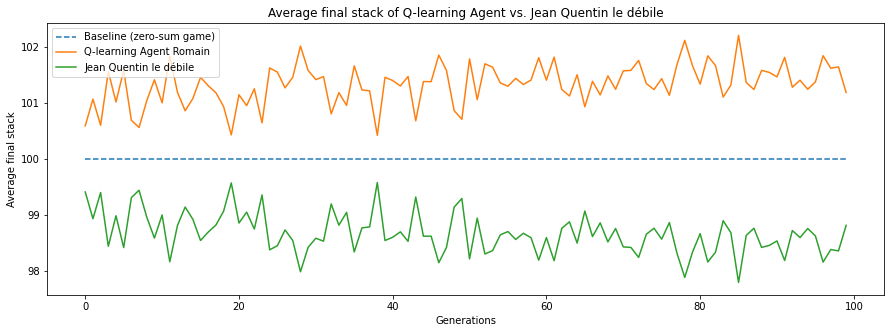

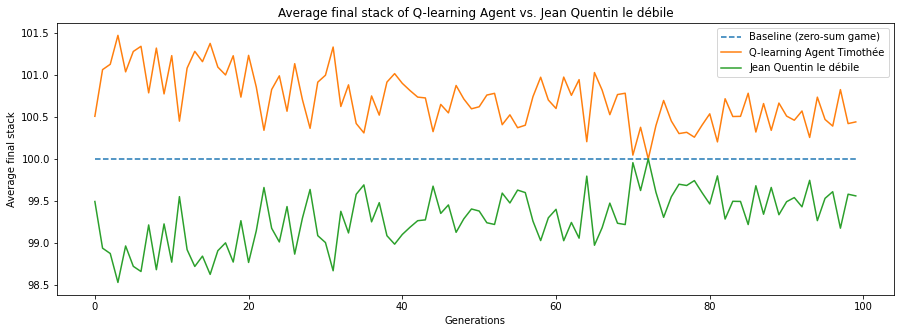

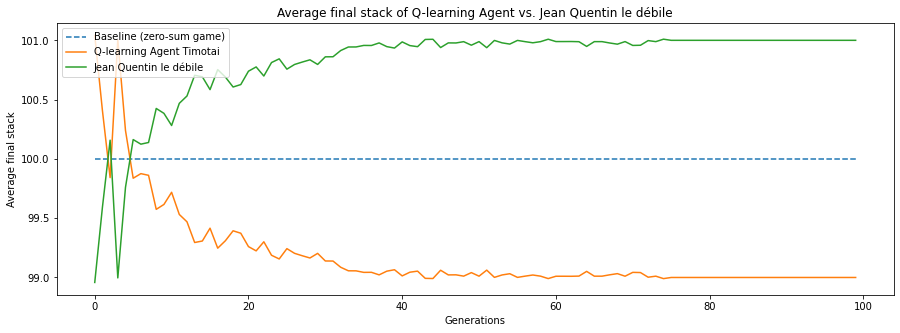

L'agent est big_blind : True


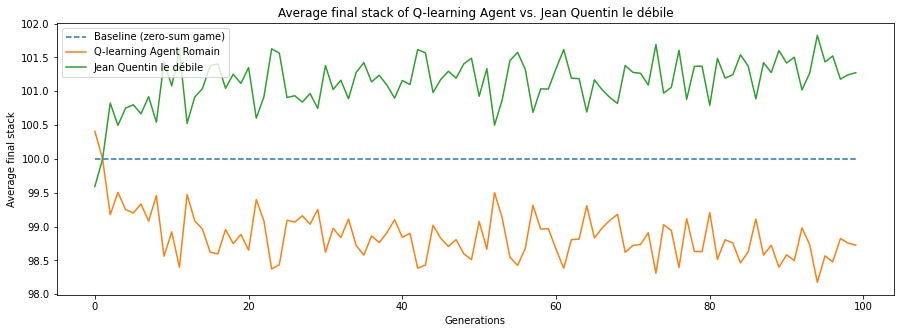

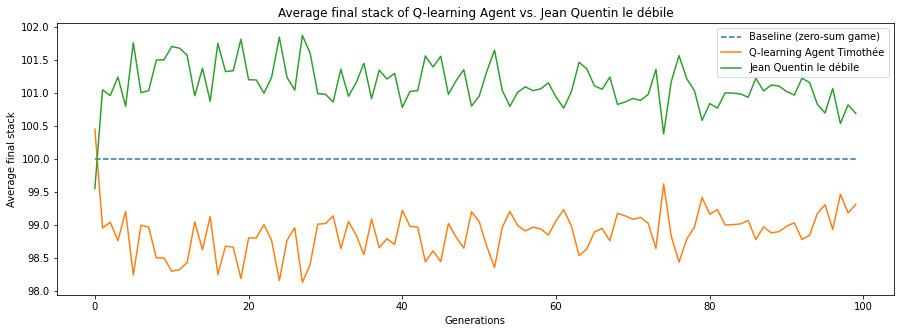

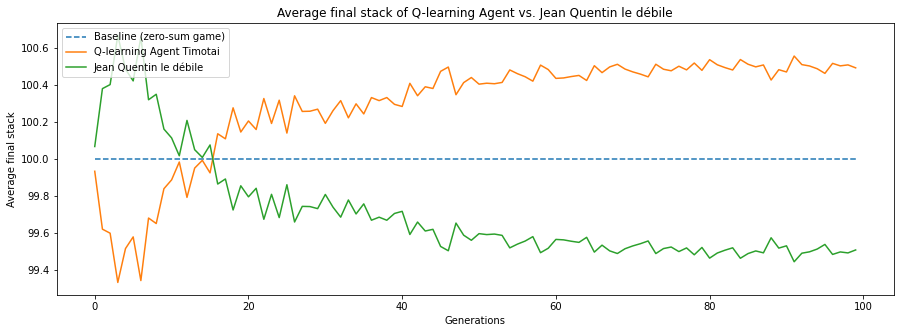

In [135]:
generation = 100

display_text = False

for big_blind_agent in [0, 1]:
    print(f"L'agent est big_blind : {big_blind_agent == 1}")
    average_per_generation_player_0 = [[], [], []]  # liste de liste de taille int(3 * num_episodes/100 + 1)
    average_per_generation_player_1 = [[], [], []]  # liste de taille int(3 * num_episodes/100 + 1)
    for i, agent in enumerate(agents_finaux[big_blind_agent]):
        for tranche in range(0, generation):
            # not optimal in terms of complexity but list comprehension look pretty don't they
            tranche = tranche/generation
            first_episode_tranche = int(tranche*num_episodes)
            last_episode_tranche = int((tranche+1/generation)*num_episodes)
            if display_text:
                print(f"Episodes {first_episode_tranche} à {last_episode_tranche-1}")
            liste_stacks_a_la_fin_player_0 = [x[0] for x in stacks_a_la_fin_finaux[big_blind_agent][i][first_episode_tranche:last_episode_tranche]]
            average_per_generation_player_0[i].append(np.mean(liste_stacks_a_la_fin_player_0))
            liste_stacks_a_la_fin_player_1 = [x[1] for x in stacks_a_la_fin_finaux[big_blind_agent][i][first_episode_tranche:last_episode_tranche]]
            average_per_generation_player_1[i].append(np.mean(liste_stacks_a_la_fin_player_1))
            if display_text:
                print(f"Agent 0: {round(np.mean(liste_stacks_a_la_fin_player_0), 2)} vs agent 1: {round(np.mean(liste_stacks_a_la_fin_player_1), 2)}")

    display_plot = True
    if display_plot:
        agents_legendes = ["Q-learning Agent Romain", "Q-learning Agent Timothée", "Q-learning Agent Timotai"]
        for i in range(0, 3):
            plt.figure(figsize=(15, 5), facecolor='w', edgecolor='k')
            plt.plot([100 for _ in range(len(average_per_generation_player_0[0]))], linestyle="--")
            plt.plot(average_per_generation_player_0[i])
            plt.plot(average_per_generation_player_1[i])
            plt.title("Average final stack of Q-learning Agent vs. Jean Quentin le débile")
            plt.legend(("Baseline (zero-sum game)", agents_legendes[i], "Jean Quentin le débile"))
            plt.xlabel("Generations")
            plt.ylabel("Average final stack")
            plt.show()

Le dernier (gros steps_size) peut partir dans un minimum local bien bien pourri parce qu'en gros il accorde beaucoup d'importance aux dernières mains et il explore de moins en moins donc s'il a pas de chance plusieurs fois avec AA par exemple, il va que fold et donc va systématiquement perdre.